In [2]:
from bertopic import BERTopic
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [4]:
import pickle

In [5]:
with open('./filtered_Main.pkl', 'rb') as f:
    data1=pickle.load(f)
with open('./filtered_Methods.pkl', 'rb') as f2:
    data2=pickle.load(f2)
with open('./filtered_Sum.pkl', 'rb') as f3:
    data3=pickle.load(f3)

In [6]:
import umap
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
#%matplotlib tk
#%matplotlib widget

In [7]:
plt.rcParams['figure.figsize'] = [15, 15]

In [8]:
embeddings1 = model.encode(data3, convert_to_tensor=True)
embeddings2 = model.encode(data1, convert_to_tensor=True)
embeddings3 = model.encode(data2, convert_to_tensor=True)
embeddings4=model.encode(data1+data2+data3, convert_to_tensor=True)

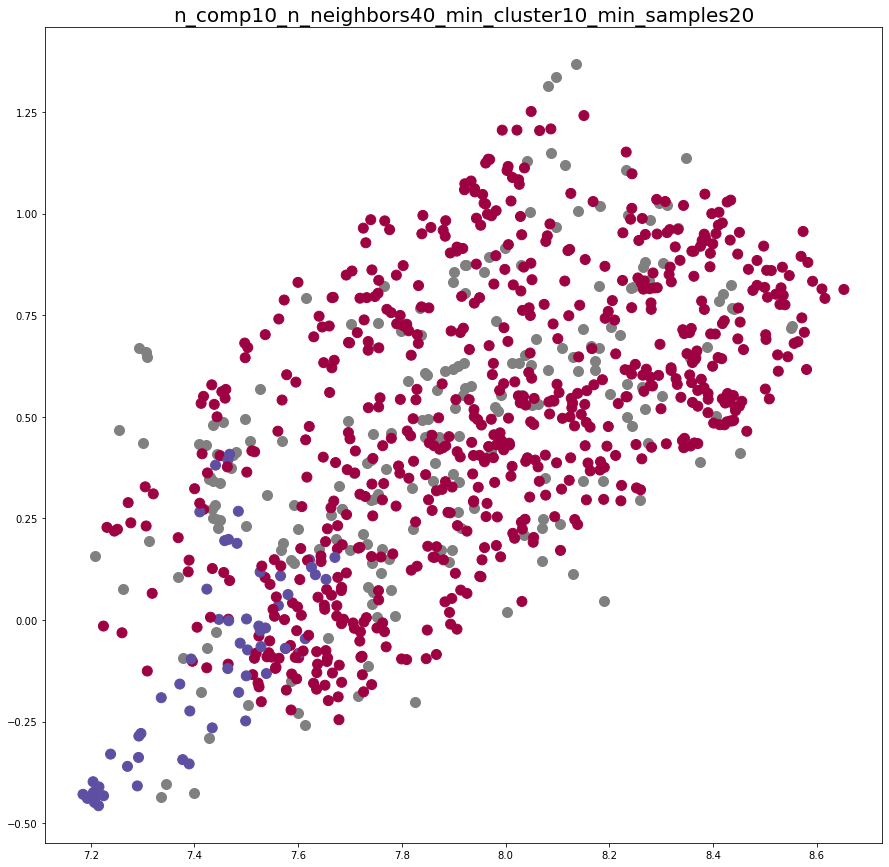

In [9]:
# Summary 2 | 80 | 1 | 20
n_comp_set=[10] #2D, 3D,..., 고차원
n_neighbors_set=[40] # Local vs Gloabl 늘리면 늘릴 수록 dispersion 됨
min_samples=[10] # Clustering을 어느 정도로 할지
min_cluster_size=[20] # Clustering를 고려하려는 가장 작은 크기의 그룹
for i in n_comp_set:
    for k in n_neighbors_set:
        standard_embedding = umap.UMAP( n_neighbors=k, min_dist=0.0, n_components=i, random_state=42,).fit_transform(embeddings1.cpu())
        for ii in min_samples:
            for kk in min_cluster_size:   
                labels = hdbscan.HDBSCAN(min_samples=ii, min_cluster_size=kk).fit_predict(standard_embedding)
                clustered = (labels >= 0)
                plt.scatter(standard_embedding[~clustered, 0],
                standard_embedding[~clustered, 1],
                color=(0.5, 0.5, 0.5),
                s=100,
                alpha=1)
                plt.scatter(standard_embedding[clustered, 0],
                standard_embedding[clustered, 1],
                c=labels[clustered],
                s=100,
                cmap='Spectral');
                plt.title(f'n_comp{i}_n_neighbors{k}_min_cluster{ii}_min_samples{kk}', size=20)
                plt.show()

In [10]:
Summary=pd.concat([pd.DataFrame(data3),pd.DataFrame(labels,columns=['labels'])],axis=1)

In [39]:
#Summary.to_csv('Sum.csv')

In [15]:
def _extract_topics(self, documents: pd.DataFrame):
    """ Extract topics from the clusters using a class-based TF-IDF

    Arguments:
        documents: Dataframe with documents and their corresponding IDs

    Returns:
        c_tf_idf: The resulting matrix giving a value (importance score) for each word per topic
    """
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    self.c_tf_idf, words = self._c_tf_idf(documents_per_topic)
    self.topics = self._extract_words_per_topic(words)
    self._create_topic_vectors()
    self.topic_names = {key: f"{key}_" + "_".join([word[0] for word in values[:4]])
                        for key, values in
                        self.topics.items()}

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
vectorizer_model=CountVectorizer(stop_words="english", ngram_range=(2, 4), min_df=1,max_df = 0.5)

In [21]:
vectorizer_model.fit(Summary[Summary['labels'] == 1][0].to_list())

CountVectorizer(max_df=0.5, ngram_range=(2, 4), stop_words='english')

In [23]:
words = vectorizer_model.get_feature_names()

In [25]:
X = vectorizer_model.transform(Summary[Summary['labels'] == 1][0].to_list())

In [30]:
transformer = ClassTFIDF().fit(X, multiplier=None)

In [32]:
c_tf_idf = transformer.transform(X)

In [48]:
indices = []
for le, ri in zip(c_tf_idf.indptr[:-1], c_tf_idf.indptr[1:]):
    n_row_pick = min(30, ri - le)
    values = c_tf_idf.indices[le + np.argpartition(c_tf_idf.data[le:ri], -n_row_pick)[-n_row_pick:]]
    values = [values[index] if len(values) >= index + 1 else None for index in range(30)]
    indices.append(values)
indices=np.array(indices)

In [49]:
top_values = []
for row, values in enumerate(indices):
    scores = np.array([c_tf_idf[row, value] if value is not None else 0 for value in values])
    top_values.append(scores)
scores=np.array(top_values)

In [51]:
sorted_indices = np.argsort(scores, 1)
indices = np.take_along_axis(indices, sorted_indices, axis=1)
scores = np.take_along_axis(scores, sorted_indices, axis=1)

# Get top 30 words per topic based on c-TF-IDF score
topics = {label: [(words[word_index], score)
                  if word_index is not None and score > 0
                  else ("", 0.00001)
                  for word_index, score in zip(indices[index][::-1], scores[index][::-1])
                  ]
          for index, label in enumerate(labels)}

IndexError: index 58 is out of bounds for axis 0 with size 58

In [ ]:
if self.diversity is not None:
    if self.embedding_model is not None:

        for topic, topic_words in topics.items():
            words = [word[0] for word in topic_words]
            word_embeddings = self._extract_embeddings(words,
                                                       method="word",
                                                       verbose=False)
            topic_embedding = self._extract_embeddings(" ".join(words),
                                                       method="word",
                                                       verbose=False).reshape(1, -1)
            topic_words = mmr(topic_embedding, word_embeddings, words,
                              top_n=self.top_n_words, diversity=self.diversity)
            topics[topic] = [(word, value) for word, value in topics[topic] if word in topic_words]
topics = {label: values[:self.top_n_words] for label, values in topics.items()}

return topics

In [ ]:
Summary[Summary['labels'] == 1][0].to_list()

TypeError: list indices must be integers or slices, not tuple

In [29]:
from keybert import KeyBERT

In [30]:
kw_model = KeyBERT('distilbert-base-nli-mean-tokens')

In [36]:
eywords=kw_model.extract_keywords(Summary[Summary['labels'] == 0][0].to_list(),keyphrase_ngram_range=(1,3), stop_words='english',use_mmr=True, diversity= 0.2)

In [ ]:
keywords

In [ ]:
Summary[Summary['labels'] ==1][0].to_list()

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
from sklearn.utils import check_array
import numpy as np
import scipy.sparse as sp


class ClassTFIDF(TfidfTransformer):
    """
    A Class-based TF-IDF procedure using scikit-learns TfidfTransformer as a base.

    ![](../img/ctfidf.png)

    C-TF-IDF can best be explained as a TF-IDF formula adopted for multiple classes
    by joining all documents per class. Thus, each class is converted to a single document
    instead of set of documents. Then, the frequency of words **t** are extracted for
    each class **i** and divided by the total number of words **w**.
    Next, the total, unjoined, number of documents across all classes **m** is divided by the total
    sum of word **i** across all classes.
    """
    def __init__(self):
        super(ClassTFIDF, self).__init__()

    def fit(self, X: sp.csr_matrix, multiplier: np.ndarray = None):
        """Learn the idf vector (global term weights).

        Arguments:
            X: A matrix of term/token counts.
            multiplier: A multiplier for increasing/decreasing certain IDF scores
        """
        X = check_array(X, accept_sparse=('csr', 'csc'))
        if not sp.issparse(X):
            X = sp.csr_matrix(X)
        dtype = np.float64

        if self.use_idf:
            _, n_features = X.shape

            # Calculate the frequency of words across all classes
            df = np.squeeze(np.asarray(X.sum(axis=0)))

            # Calculate the average number of samples as regularization
            avg_nr_samples = int(X.sum(axis=1).mean())

            # Divide the average number of samples by the word frequency
            # +1 is added to force values to be positive
            idf = np.log((avg_nr_samples / df)+1)

            # Multiplier to increase/decrease certain idf scores
            if multiplier is not None:
                idf = idf * multiplier

            self._idf_diag = sp.diags(idf, offsets=0,
                                      shape=(n_features, n_features),
                                      format='csr',
                                      dtype=dtype)

        return self

    def transform(self, X: sp.csr_matrix):
        """Transform a count-based matrix to c-TF-IDF

        Arguments:
            X (sparse matrix): A matrix of term/token counts.

        Returns:
            X (sparse matrix): A c-TF-IDF matrix
        """
        if self.use_idf:
            X = normalize(X, axis=1, norm='l1', copy=False)
            X = X * self._idf_diag

        return X


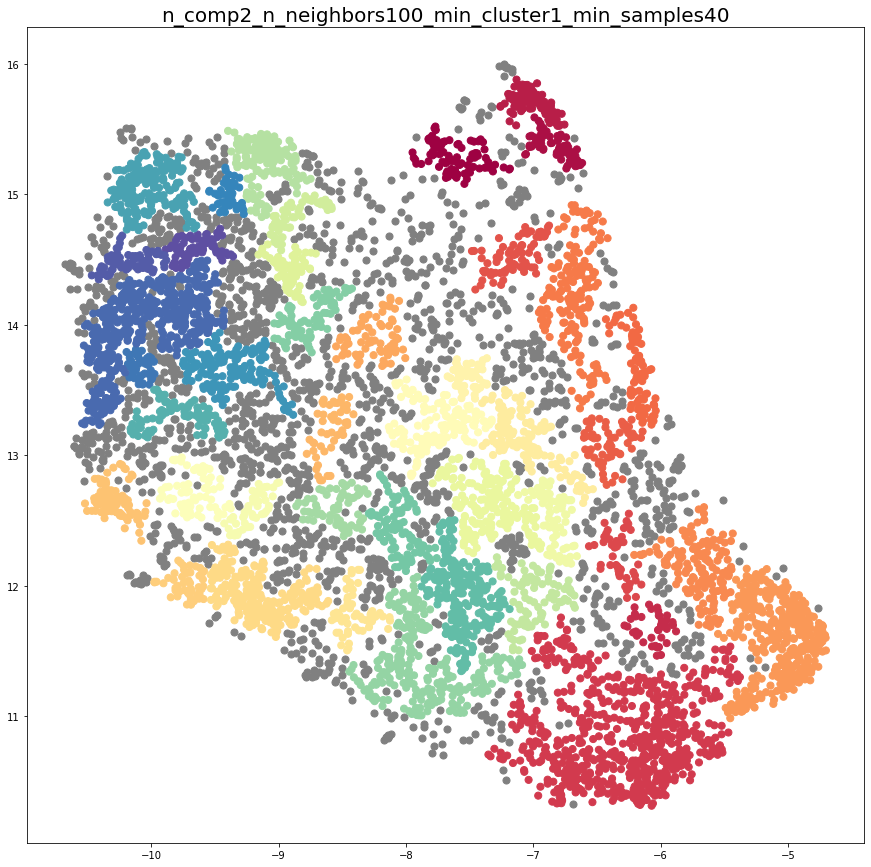

In [24]:
# Main 2 | 100 | 1 | 50
n_comp_set=[2] #2D, 3D,..., 고차원
n_neighbors_set=[100] # Local vs Gloabl 늘리면 늘릴 수록 dispersion 됨
min_samples=[1] # Clustering을 어느 정도로 할지
min_cluster_size=[40] # Clustering를 고려하려는 가장 작은 크기의 그룹
for i in n_comp_set:
    for k in n_neighbors_set:
        standard_embedding2 = umap.UMAP( n_neighbors=k, min_dist=0.0, n_components=i, random_state=42,).fit_transform(embeddings2.cpu())
        for ii in min_samples:
            for kk in min_cluster_size:        
                labels2 = hdbscan.HDBSCAN(min_samples=ii, min_cluster_size=kk).fit_predict(standard_embedding2)
                clustered2 = (labels2 >= 0)
                plt.scatter(standard_embedding2[~clustered2, 0],
                standard_embedding2[~clustered2, 1],
                color=(0.5, 0.5, 0.5),
                s=50,
                alpha=1)
                plt.scatter(standard_embedding2[clustered2, 0],
                standard_embedding2[clustered2, 1],
                c=labels2[clustered2],
                s=50,
                cmap='Spectral');
                plt.title(f'n_comp{i}_n_neighbors{k}_min_cluster{ii}_min_samples{kk}', size=20)
                plt.show()

In [25]:
Main=pd.concat([pd.DataFrame(data1),pd.DataFrame(labels2,columns=['labels'])],axis=1)

In [40]:
Main.to_csv('Main.csv')

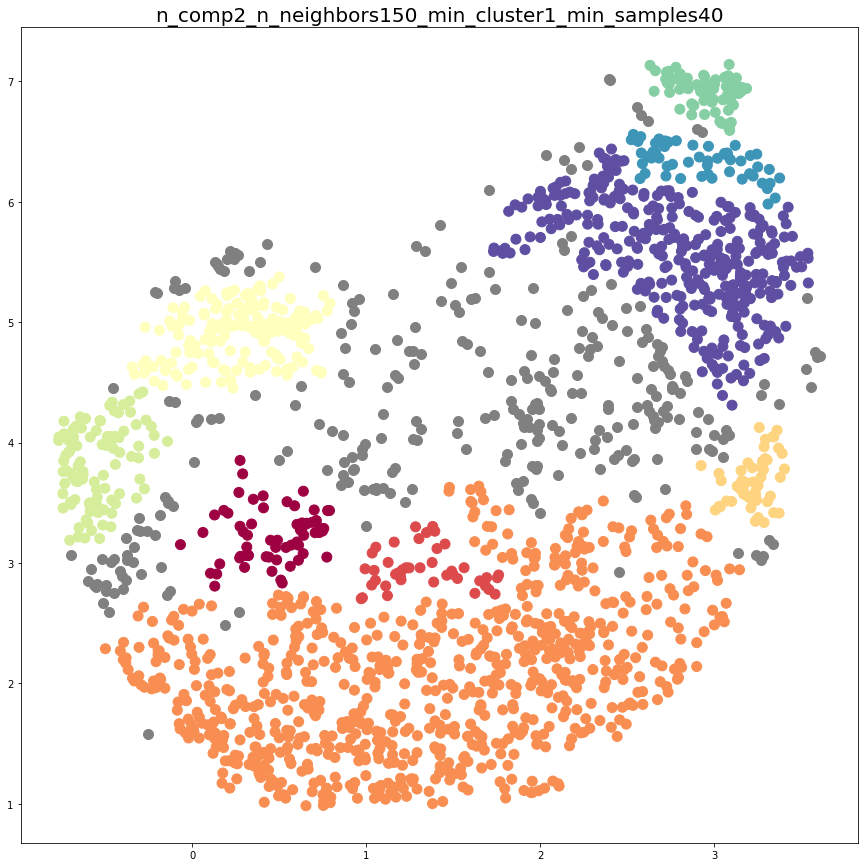

In [17]:
# Method 2 | 150 | 1 | 40
n_comp_set=[2] #2D, 3D,..., 고차원
n_neighbors_set=[150] # Local vs Gloabl 늘리면 늘릴 수록 dispersion 됨
min_samples=[1] # Clustering을 어느 정도로 할지
min_cluster_size=[40] # Clustering를 고려하려는 가장 작은 크기의 그룹
for i in n_comp_set:
    for k in n_neighbors_set:
        standard_embedding3 = umap.UMAP( n_neighbors=k, min_dist=0.0, n_components=i, random_state=42,).fit_transform(embeddings3.cpu())
        for ii in min_samples:
            for kk in min_cluster_size:        
                labels3 = hdbscan.HDBSCAN(min_samples=ii, min_cluster_size=kk).fit_predict(standard_embedding3)
                clustered3 = (labels3 >= 0)
                plt.scatter(standard_embedding3[~clustered3, 0],
                standard_embedding3[~clustered3, 1],
                color=(0.5, 0.5, 0.5),
                s=100,
                alpha=1)
                plt.scatter(standard_embedding3[clustered3, 0],
                standard_embedding3[clustered3, 1],
                c=labels3[clustered3],
                s=100,
                cmap='Spectral');
                plt.title(f'n_comp{i}_n_neighbors{k}_min_cluster{ii}_min_samples{kk}', size=20)
                plt.show()

In [26]:
Method=pd.concat([pd.DataFrame(data2),pd.DataFrame(labels3,columns=['labels'])],axis=1)

In [41]:
Method.to_csv('Method.csv')

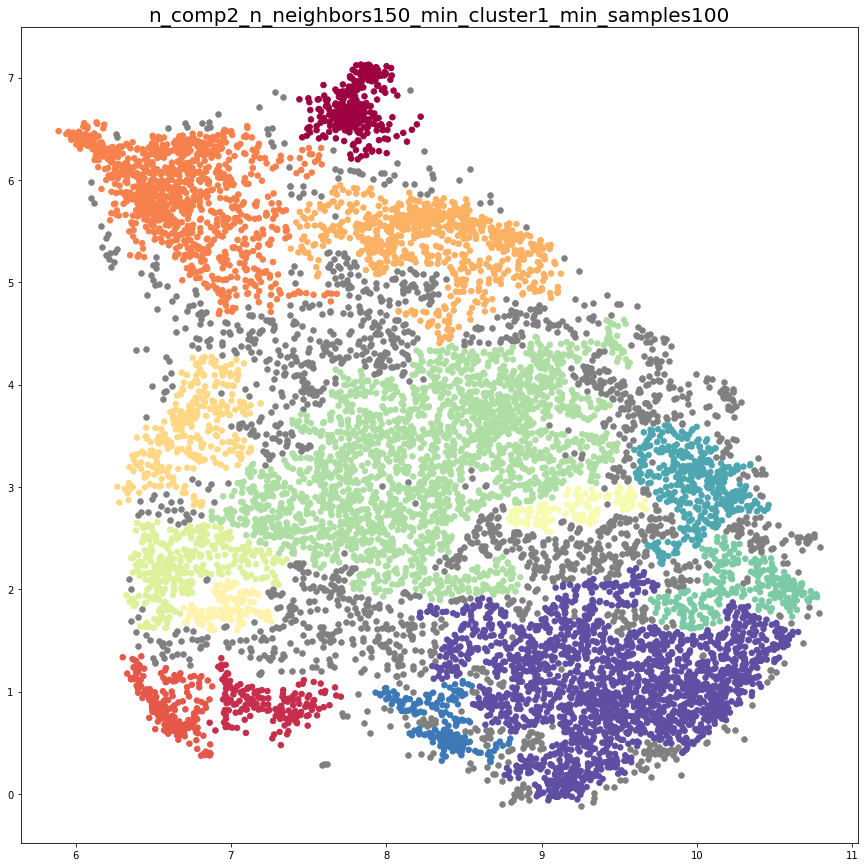

In [19]:
n_comp_set=[2] #2D, 3D,..., 고차원
n_neighbors_set=[200] # Local vs Gloabl 늘리면 늘릴 수록 dispersion 됨
min_samples=[1] # Clustering을 어느 정도로 할지
min_cluster_size=[100] # Clustering를 고려하려는 가장 작은 크기의 그룹
for i in n_comp_set:
    for k in n_neighbors_set:
        standard_embedding4 = umap.UMAP( n_neighbors=k, min_dist=0.0, n_components=i, random_state=42,).fit_transform(embeddings4.cpu())
        for ii in min_samples:
            for kk in min_cluster_size:        
                labels4 = hdbscan.HDBSCAN(min_samples=ii, min_cluster_size=kk).fit_predict(standard_embedding4)
                clustered4 = (labels4 >= 0)
                plt.scatter(standard_embedding4[~clustered4, 0],
                standard_embedding4[~clustered4, 1],
                color=(0.5, 0.5, 0.5),
                s=30,
                alpha=1)
                plt.scatter(standard_embedding4[clustered4, 0],
                standard_embedding4[clustered4, 1],
                c=labels4[clustered4],
                s=30,
                cmap='Spectral');
                plt.title(f'n_comp{i}_n_neighbors{k}_min_cluster{ii}_min_samples{kk}', size=20)
                plt.show()

In [27]:
Total=pd.concat([pd.DataFrame(data1+data2+data3),pd.DataFrame(labels4,columns=['labels'])],axis=1)

In [42]:
Total.to_csv('Total.csv')